# What next?

You now have the discharges and time between the detection sites.  What to do next?

In [1]:
using NBInclude
@nbinclude("4_process_traces.ipynb") # load previous work
using CSV, DataFrames
using MonteCarloMeasurements, Distributions
using GLMakie
using Dates

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000818±2.8e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000812±9.9e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000456±5.18e-6

958: 9.700806565484955 sd: 9.842223520028694 530: 8.798080978404498 delta_calib_958: 0.1414169545437396 delta_delta_calib_530: 1.044142541624197 delta_calib_554: 0.006539618492093169

## Stage-discharge relation and continuous Q

In [2]:
## Delete?

#create Dict "qsv" with q_InjCTD, s, v_InjCTD of each injection

# Step 1: Create arrays for dates and times
dates = ["09.08.2024", "09.08.2024", "09.08.2024", "09.08.2024", "09.08.2024", 
         "09.08.2024", "09.08.2024", "09.08.2024", "11.08.2024", "11.08.2024"]

times = ["09:33:00", "10:11:00", "10:43:00", "11:41:00", "14:16:00", 
         "14:59:00", "16:25:00", "15:40:00", "09:19:00", "12:59:00"]

# Step 2: Define the first and second values arrays
stream_no = [2, 3, 4, 1, 2, 3, 1, 4, 1, 5] #5 is 1upper
q = [0.084, 0.18, 0.21, 0.59, 0.22, 0.29, 0.77, 0.25, 0.074, 0.34]
s = [0.195124, NaN, 0.127199, 0.195725, 0.300219, NaN, 0.228056, 0.130708, 0.00791984, NaN] #NaNs from streams 03 and 01upper
v = [0.594889706, 0.975307692, 1.000909091, 1.29375, 0.881798365, 
                 1.280707071, 1.528977273, 1.000909091, 0.459215017, 1.278030303]
w = q./v./s
w[9] = NaN #impossible, probably bc out of water

# Step 3: Create an empty dictionary to hold DateTime keys and value arrays
qsv = Dict{DateTime, Vector{Float64}}()

# Step 4: Populate the dictionary with DateTime keys and [first_value, second_value] arrays
array_t_injection = DateTime[]
for i in 1:length(dates)
    # Combine date and time into DateTime
    t_injection = DateTime(dates[i] * " " * times[i], "dd.mm.yyyy HH:MM:SS")
    push!(array_t_injection, t_injection)
    
    # Create the value array for this DateTime
    value_array = [stream_no[i], q[i], s[i], v[i]]
    
    # Add the DateTime key and the value array to the dictionary
    qsv[t_injection] = value_array
end

### Time series of stage
Match the dicts with air pressure and water pressure on time 

Subtract air pressure from water pressure -> gives pressure head

Filter for periods where sensor was out of water

Correct for jumps where sensor moved in the water

In [3]:
#matches dicts with water and air pressure on the same time. stage is calculated as air pressure (m H20) - water pressure (m H20) 

#match dicts with water and air pressure on date

#creates temporary dict with :t as key and :press as value and round them to the nearest minute

function round_dict(dictname) #creates dict with with :t as key and :press as value
dict_rounded = Dict() #initialise dict
j = 1
for i in dictname[:t]
        # Round to the nearest minute
        rounded_i = Dates.DateTime(
        year(i), month(i), day(i), hour(i), minute(i), 0
) + Dates.Minute(round(Int, second(i) / 60))
        
    dict_rounded[rounded_i] = dictname[:press][j]
    j += 1
end
return dict_rounded
end

#add uncertainties to pressure values
p_uncert = 0.0005 * (2-0.8)*100/9.81  #uncertainty of pressure sensors
d_sd[:press] = d_sd[:press] .+ ± p_uncert
d_554_calib[:press] = d_554_calib[:press] .+ ± p_uncert
d_530_calib[:press] = d_530_calib[:press] .+ ± p_uncert
d_958_calib[:press] = d_958_calib[:press] .+ ± p_uncert

#run round_dict for all dicts
d_sd_rounded = round_dict(d_sd)
d_554_rounded = round_dict(d_554_calib)
d_530_rounded = round_dict(d_530_calib)
d_958_rounded = round_dict(d_958_calib)

# Find common keys (dates) between the two dictionaries
function calc_stage(dict1, dict2 = d_sd_rounded)
common_dates = intersect(keys(dict1), keys(dict2))
stage_date = Dict()

for date in common_dates
    stage_date[date] = (dict1[date] - dict2[date])
end
return(stage_date)
end

#run calc_stage for all dicts and sort by date, output stores: date => stage [m]
d_554_stage = sort(calc_stage(d_554_rounded))
d_530_stage = sort(calc_stage(d_530_rounded))
d_958_stage = sort(calc_stage(d_958_rounded))

function change_keys(d) #makes :t and :s the new keys
    stage_array = []
    t_array = []
    for i in keys(d)
        push!(stage_array, d[i])
        push!(t_array, i)
    end
    s = Dict()
    s[:s] = stage_array
        s[:t] = t_array
    return s
end

#output dicts with :t and :s as new keys
sq1 = change_keys(d_554_stage)
sq2 = change_keys(d_530_stage)
sq4 = change_keys(d_958_stage);

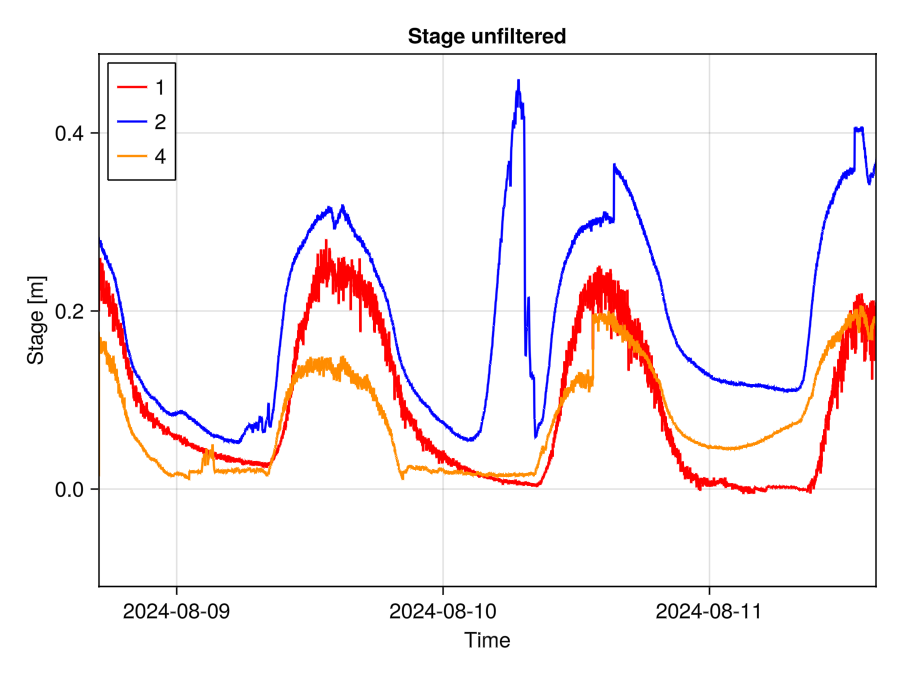

GLMakie.Screen(...)

In [4]:
#plot stage
Makie.inline!(true)
using Dates
fig = Figure()
ax = Axis(fig[1,1], title = "Stage unfiltered", xlabel = "Time", ylabel = "Stage [m]")
colors = [:red, :blue, :green, :darkorange, :pink]
lines!(ax, sq1[:t], sq1[:s], label = "1", color = colors[1])
lines!(ax, sq2[:t], sq2[:s], label = "2", color = colors[2])
lines!(ax, sq4[:t], sq4[:s], label = "4", color = colors[4])

xmin = DateTime(2024, 8, 8, 17, 00, 0)
xmax = DateTime(2024, 8, 11, 15, 00, 0)
xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :lt)
display(fig)

In [26]:
#filter values where pressure sensor presumably was out of water 
#correct offset where sensor suddenly moved

unsafe_comparisons(true) #reduces particles to floating numbers (using the mean) for comparison reasons
#filter where stage 4 < 5cm and  remove time period from 2024-08-09 02:00:00 to 04:00:00
t1 = DateTime(2024, 8, 9, 2, 00, 0)
t2 = DateTime(2024, 8, 9, 4, 00, 0)
for i in 1:length(sq4[:s]) 
        if sq4[:s][i] < 0.04
            sq4[:s][i] = NaN ± 0.0
        end
        if (sq4[:t][i] > t1) && (sq4[:t][i] < t2)
            sq4[:s][i] = NaN ± 0.0
        end
end

#remove stage 1 for time period from 2024-08-10 22:00:00 to 2024-08-11 09:00:00
t3 = DateTime(2024, 8, 10, 22, 00, 0)
t4 = DateTime(2024, 8, 11, 9, 00, 0)
for i in 1:length(sq1[:s]) 
        if (sq1[:t][i] > t3) && (sq1[:t][i] < t4)
            sq1[:s][i] = NaN ± 0.0
        end
end

"""
#remove nighttime peak of 2 -> remove time periode from 2024-08-10 02:00:00 to 08:30:00
t5 = DateTime(2024, 8, 10, 2, 00, 0)
t6 = DateTime(2024, 8, 10, 8, 30, 0)
for i in 1:length(sq2[:s]) 
        if (sq2[:t][i] > t5) && (sq2[:t][i] < t6)
            sq2[:s][i] = NaN
        end
end
"""

#correct offset
#stage 2: 0.304 at 2024-08-10 15:23, jump to 0.3666 at 15:25
#stage 4: 0.1254 at 2024-08-10 13:30, jump to 0.1968 at 13:31


t_jump2 = DateTime(2024, 8, 10, 15, 23, 0)
t_jump2_after = DateTime(2024, 8, 10, 15, 25, 0)
delta_jump2 = sq2[:s][sq2[:t] .== t_jump2_after] - sq2[:s][sq2[:t] .== t_jump2]

sq2[:s][sq2[:t] .> t_jump2] = sq2[:s][sq2[:t] .> t_jump2] .- delta_jump2


t_jump4 = DateTime(2024, 8, 10, 13, 30, 0)
t_jump4_after = DateTime(2024, 8, 10, 13, 31, 0)
delta_jump4 = sq4[:s][sq4[:t] .== t_jump4_after] - sq4[:s][sq4[:t] .== t_jump4]
sq4[:s][sq4[:t] .> t_jump4] = sq4[:s][sq4[:t] .> t_jump4] .- delta_jump4;

[ Info: Unsafe comparisons using the function `pmean` has been enabled globally. Use `@unsafe` to enable in a local expression only or `unsafe_comparisons(false)` to turn off unsafe comparisons


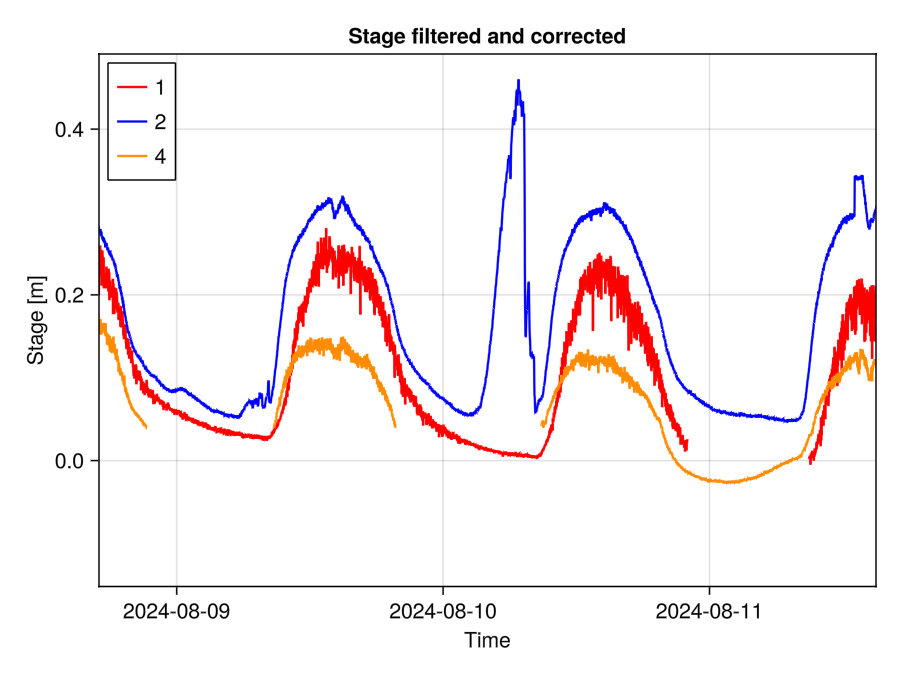

GLMakie.Screen(...)

In [27]:
#plot filtered stage
Makie.inline!(true)
fig = Figure()
ax = Axis(fig[1,1], title = "Stage filtered and corrected", xlabel = "Time", ylabel = "Stage [m]")
colors = [:red, :blue, :green, :darkorange, :pink]
lines!(ax, sq1[:t], sq1[:s], label = "1", color = colors[1])
lines!(ax, sq2[:t], sq2[:s], label = "2", color = colors[2])
lines!(ax, sq4[:t], sq4[:s], label = "4", color = colors[4])

xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :lt)
display(fig)

### Find parameters of linear stage-discharge-relation 
Create Dict with values from stage and discharge when we did the salt dilution traces

Function based on a modification of the  calibration functions we used for the conductivity-salt_conc-relation. This function can handle uncertainties using MonteCarloMeasurements

In [28]:
# Read output file from traces with discharges und Runtimes
traces_full = CSV.read("../data/products/2024_Konki/output_Trapez.csv", DataFrame)
traces_full.Date = Date.(traces_full.Date, "dd.mm.yyyy")
traces_full.t_inj = DateTime.(traces_full.Date, traces_full."Injection time")
traces = traces_full[:, ["Location", "t_inj", "Q1", "Q2", "t1", "t2"]]
traces[10, "Location"] = "5"
traces.Location = parse.(Int, traces.Location)
rename!(traces, [:loc, :t_inj, :Q1, :Q2, :t1, :t2])
traces.t1 = traces.t1 ± 5
traces.t2 = traces.t2 ± 2
tracesQ1_helper = copy(traces.Q1) #helper vector since the uncertainty cannot be NaN and i am using relative uncertainties -> put those uncertainties to 0 instead of NaN
tracesQ1_helper[1:2] = [0.0, 0.0]
traces.Q1 = traces.Q1 .± tracesQ1_helper.*0.1
traces.Q2 = traces.Q2 .± traces.Q2.*0.1
traces = sort(traces, :loc)

Row,loc,t_inj,Q1,Q2,t1,t2
,Int64,DateTime,Particle…,Particle…,Particle…,Particle…
1,1,2024-08-09T11:41:00,0.47 ± 0.047,0.59 ± 0.059,49.9 ± 5.0,104.0 ± 2.0
2,1,2024-08-09T16:25:06,0.61 ± 0.061,0.77 ± 0.077,30.1 ± 5.2,88.0 ± 2.1
3,1,2024-08-11T09:18:35,0.065 ± 0.0065,0.074 ± 0.0074,115.0 ± 5.1,293.0 ± 1.9
4,2,2024-08-09T09:32:50,NaN ± NaN,0.084 ± 0.0084,NaN ± NaN,544.0 ± 2.0
5,2,2024-08-09T14:15:14,0.14 ± 0.014,0.22 ± 0.022,160.0 ± 5.0,367.0 ± 2.0
6,3,2024-08-09T10:11:00,NaN ± NaN,0.18 ± 0.018,NaN ± NaN,130.0 ± 2.0
7,3,2024-08-09T14:59:25,0.23 ± 0.023,0.29 ± 0.029,40.2 ± 4.9,98.9 ± 2.0
8,4,2024-08-09T10:42:30,0.15 ± 0.015,0.21 ± 0.021,14.8 ± 4.9,121.0 ± 2.1
9,4,2024-08-09T15:40:05,0.22 ± 0.022,0.25 ± 0.025,19.8 ± 4.9,121.0 ± 2.0


In [71]:
#variables as values

#specific helper functions
function Qvalue(streamx, i) #read discharge value from dataframe traces
    Q = traces.Q2[traces.loc .== streamx][i]
    return Q
end

function rounddt_streamx(streamx) #extracts all t_inj from measurements from one stream and rounds them to the nearest minute
    t = DateTime[]
    for i in 1:length(traces.t_inj[traces.loc .== streamx])
            rounded_i = Dates.DateTime(
            year(traces.t_inj[traces.loc .== streamx][i]), month(traces.t_inj[traces.loc .== streamx][i]), day(traces.t_inj[traces.loc .== streamx][i]), hour(traces.t_inj[traces.loc .== streamx][i]), minute(traces.t_inj[traces.loc .== streamx][i]), 0
    ) + Dates.Minute(round(Int, second(traces.t_inj[traces.loc .== streamx][i]) / 60))
        push!(t, rounded_i)
    end
    return t
end
rounddt_streamx(4)[1]

function svalue(dictname, streamx, i) #read stage value from the sq dicts
    s = dictname[:s][dictname[:t] .== rounddt_streamx(streamx)[i]]
    return s
end

sd_rel_values = Dict{Int64, Matrix{Particles}}(958=> ## stream 4
                             # first calibration
                          [ Qvalue(4,1) svalue(sq4, 4, 1) ## [discharge CTD (m^3/s, output from notebook 4) water pressure head (m H2O, read out from plot manually) - air pressure head (m H2O, read out from CSV 554 as mbar and converted right here) 
                            Qvalue(4,2) svalue(sq4, 4, 2)],
                            
                    530=> ## stream 2
                            [ Qvalue(2,1) svalue(sq2, 2, 1) ## First row needs to be the background reading! First calib with 10g/L -> actual volumes times 10
                              Qvalue(2,2) svalue(sq2, 2, 2)], #weird shape of curve -> probably clouds or smth, possible looking at global radiation from met data
                            
                    554 => ## stream 1
                           [Qvalue(1,1) svalue(sq1, 1, 1) 
                            Qvalue(1,2) svalue(sq1, 1, 2)
                            Qvalue(1,3) svalue(sq1, 1, 3)],#out of water? -> filter data from night from 554!
                            );

Dict{Int64, Matrix{Particles}} with 3 entries:
  530 => [0.084 ± 0.0084 0.191 ± 0.0087; 0.22 ± 0.022 0.296 ± 0.0087]
  554 => [0.59 ± 0.059 0.197 ± 0.0086; 0.77 ± 0.077 0.216 ± 0.0086; 0.074 ± 0.0…
  958 => [0.21 ± 0.021 0.129 ± 0.0085; 0.25 ± 0.025 0.126 ± 0.0085]

In [55]:
#linear relation q(s) that can handle uncertainties
# move to helper_functions!!!

using LsqFit # a package for least square fitting
using MonteCarloMeasurements, GLMakie

"""
    curve_fit_MCMeasurements(model, x, y, p0)

Does LsqFit.curve_fit with MonteCarloMeasurements Vectors.  Same input as `curve_fit`.
"""
function curve_fit_MCMeasurements(model, x, y, p0)
    if eltype(x)<:Particles && eltype(y)<:Particles
        len = length(x[1].particles)
        pout = [eltype(p0)[] for p in p0]
        for i=1:len
            p = curve_fit(model, [xx.particles[i] for xx in x], [yy.particles[i] for yy in y], p0)
            @assert p.converged
            for j=1:length(p0)
                push!(pout[j], p.param[j])
            end
        end
    elseif eltype(y)<:Particles
        len = length(y[1].particles)
        pout = [eltype(p0)[] for p in p0]
        for i=1:len
            p = curve_fit(model, x, [yy.particles[i] for yy in y], p0)
            @assert p.converged "$i"
            for j=1:length(p0)
                push!(pout[j], p.param[j])
            end
        end
    elseif eltype(x)<:Particles
        len = length(x[1].particles)
        pout = [eltype(p0)[] for p in p0]
        for i=1:len
            p = curve_fit(model, [xx.particles[i] for xx in x], y, p0)
            @assert p.converged
            for j=1:length(p0)
                push!(pout[j], p.param[j])
            end
        end
    else
        error()
    end
    return [Particles(po) for po in pout]
end

"""
xs_g = 1:0.1:2
xs = xs_g ± 0.01
model = (x,p) -> x.*p[1] .+ p[2]
ys_g = (model(xs_g, [2.1, 4.3]) .+ 0.1*randn(length(xs_g)))
ys = ys_g ± 0.1
curve_fit_MCMeasurements(model, xs, ys, [1.0,1.0])
curve_fit_MCMeasurements(model, xs_g, ys, [1.0,1.0])
curve_fit_MCMeasurements(model, xs, ys_g, [1.0,1.0])
"""

LoadError: 

Estimated linear fit sensor 530: Q(s) = a + b*stage with
 a = -0.166 ± 0.049, b = 1.3 ± 0.23

Estimated linear fit sensor 554: Q(s) = a + b*stage with
 a = 0.034 ± 0.029, b = 3.14 ± 0.27

Estimated linear fit sensor 958: Q(s) = a + b*stage with
 a = 2.56 ± 1.9, b = -18.3 ± 15.0



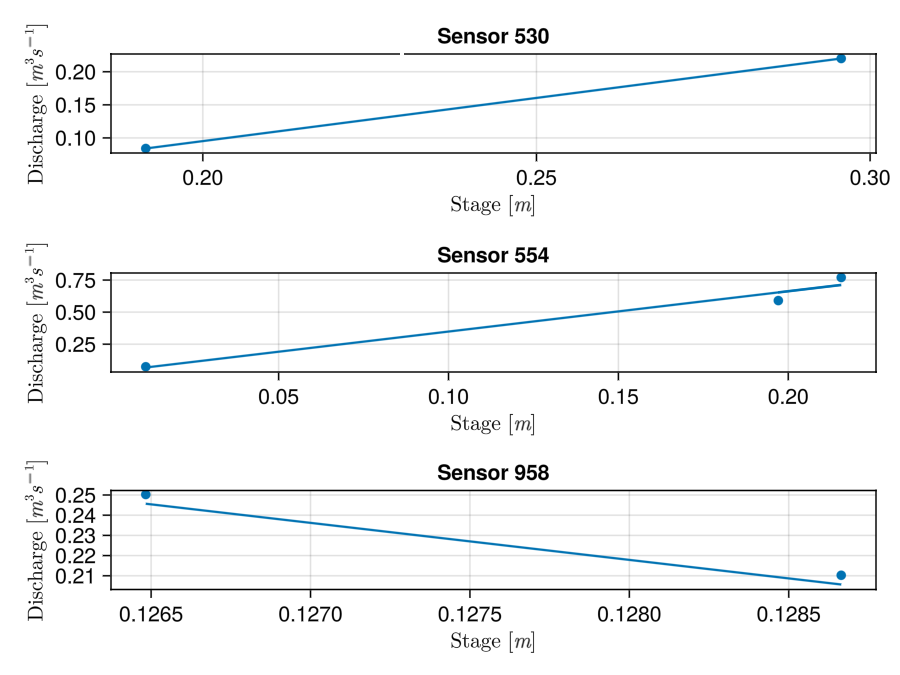

In [111]:
#linear relation q(s) using the same function as for the calibration, adapted for MC???
Makie.inline!(true)
fig2 = Figure()

id = [530, 554, 958]
sd_rel_fn_param = Dict()

for i in range(1,3)
    cali = sd_rel_values[id[i]]
    discharge = cali[:,1]
    stage = cali[:,2]
    # Fit line using https://github.com/JuliaOpt/LsqFit.jl
    #fn(stage, p) = p[1] .+ p[2]*stage ## p[1]==a, p[2]==b
    model = (stage,p) -> p[1] .+ stage.*p[2] 
    para_weights = [0.5, 0.5] ## equal weights to parameters
    fit = curve_fit_MCMeasurements(model, stage, discharge, para_weights)
    #errors = margin_error(fit, 1-0.95), no point with two data points
    println("""
    Estimated linear fit sensor $(id[i]): Q(s) = a + b*stage with
     a = $(round(fit[1],sigdigits=3)), b = $(round(fit[2],sigdigits=3))
    """)
    sd_rel_fn_param[id[i]] = [fit[1], fit[2]]

    
    Axis(fig2[i, 1], title="Sensor $(id[i])",
        xlabel=L"Stage $[m]$",
        ylabel=L"Discharge $[m^3s^{-1}$]")
    scatter!(vec(mean(Array(stage), dims = 1)), vec(mean(Array(discharge), dims = 1)))
    delta_fn = model(stage, fit)
    #calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0.2
    """for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter!(conc, cali[:,2].-cali[1,2],
                 label="Calibration 1")"""

    # Now plot the line of best fit:
    #readouts = [i for i in 0:0.01:0.2]
    # (lines! plots a line)
    lines!(vec(mean(Array(stage), dims = 1)), model(vec(mean(Array(stage), dims = 1)), vec(mean(Array(fit), dims = 1))), label="line of best fit")
    
    
end
fig2

Estimated linear fit sensor 530: Q(s) = a + b*stage with
 a = -0.169, b = 1.29

Estimated linear fit sensor 554: Q(s) = a + b*stage with
 a = 0.0436, b = 3.02

Estimated linear fit sensor 958: Q(s) = a + b*stage with
 a = -1.24, b = 11.4



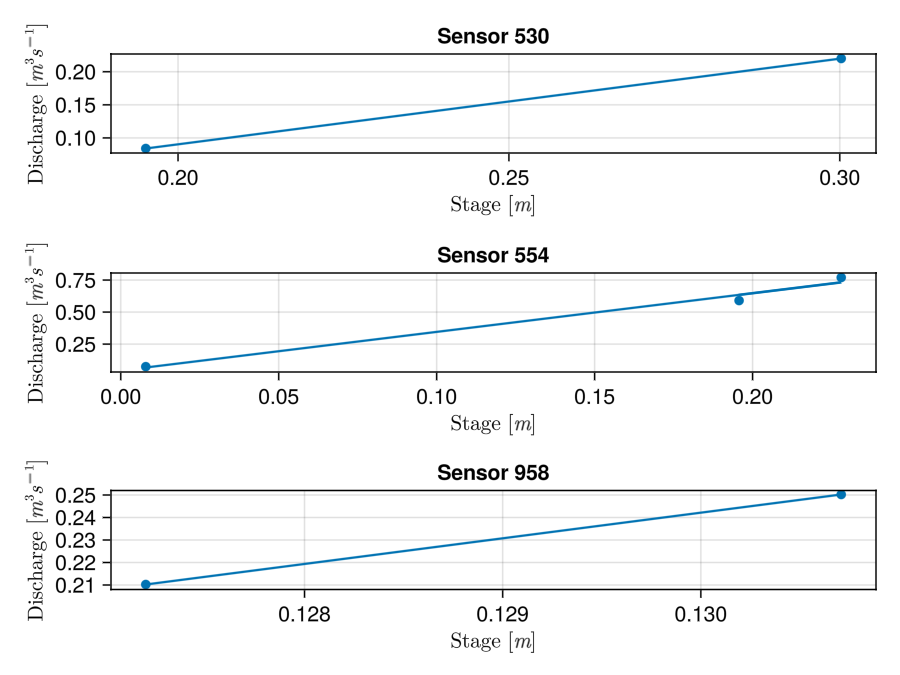

In [16]:
#linear relation q(s) using the same function as for the calibration
Makie.inline!(true)
fig2 = Figure()

id = [530, 554, 958]
sd_rel_fn_param = Dict()

for i in range(1,3)
cali = sd_rel_values[id[i]]
discharge = cali[:,1]
    stage = cali[:,2]
    # Fit line using https://github.com/JuliaOpt/LsqFit.jl
    fn(stage, p) = p[1] .+ p[2]*stage ## p[1]==a, p[2]==b
    para_weights = [0.5, 0.5] ## equal weights to parameters
    fit = curve_fit(fn, stage, discharge, para_weights)
    #errors = margin_error(fit, 1-0.95), no point with two data points
    println("""
    Estimated linear fit sensor $(id[i]): Q(s) = a + b*stage with
     a = $(round(fit.param[1],sigdigits=3)), b = $(round(fit.param[2],sigdigits=3))
    """)
    sd_rel_fn_param[id[i]] = [fit.param[1], fit.param[2]]

    
    Axis(fig2[i, 1], title="Sensor $(id[i])",
        xlabel=L"Stage $[m]$",
        ylabel=L"Discharge $[m^3s^{-1}$]")
    scatter!(stage, discharge)
    delta_fn = fn(stage, fit.param)
    #calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0.2
    """for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter!(conc, cali[:,2].-cali[1,2],
                 label="Calibration 1")"""

    # Now plot the line of best fit:
    #readouts = [i for i in 0:0.01:0.2]
    # (lines! plots a line)
    lines!(stage, fn(stage, fit.param), label="line of best fit")
    
    
end
fig2

In [17]:
sd_rel_fn_param

Dict{Any, Any} with 3 entries:
  530 => [-0.168504, 1.29407]
  554 => [0.0435599, 3.01903]
  958 => [-1.23969, 11.397]

### Implement Stage-Discharge relation and plot it

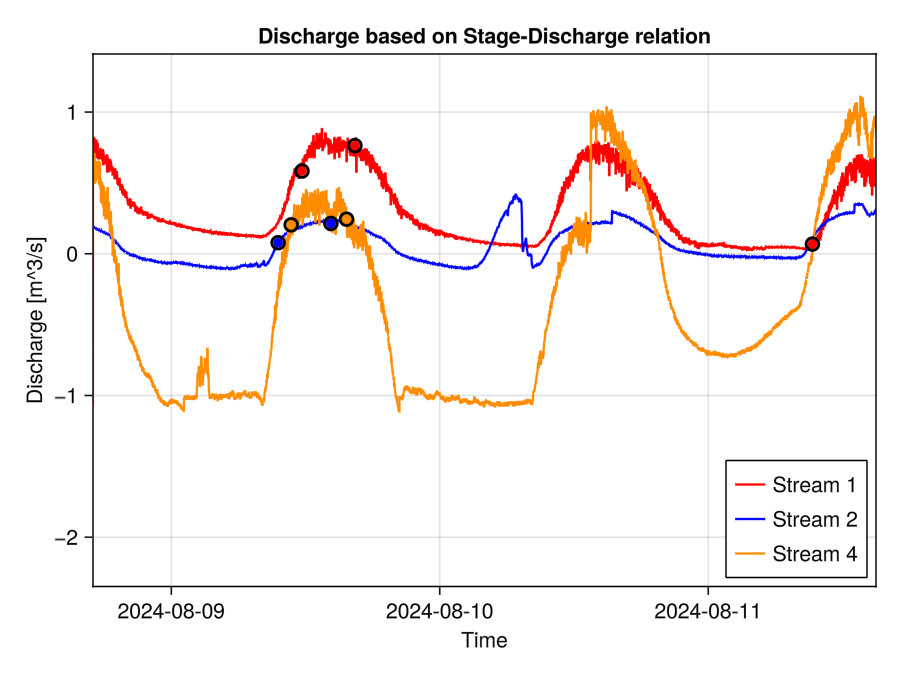

In [18]:
#plot discharge and measured discharges

Makie.inline!(false)
#apply paramaters from stage-discharge relation to the dicts with the stage
sq1[:q] = sd_rel_fn_param[554][1] .+ sd_rel_fn_param[554][2].*sq1[:s] #discharge of 554 aka stream 1
sq2[:q] = sd_rel_fn_param[530][1] .+ sd_rel_fn_param[530][2].*sq2[:s] #530
sq4[:q] = sd_rel_fn_param[958][1] .+ sd_rel_fn_param[958][2].*sq4[:s] #958


fig = Figure()
colors = [:red, :blue, :green, :darkorange, :pink]
ax = Axis(fig[1,1], title = "Discharge based on Stage-Discharge relation", xlabel = "Time", ylabel = "Discharge [m^3/s]")
lines!(ax, sq1[:t], sq1[:q], label = "Stream 1", color = colors[1])
lines!(ax, sq2[:t], sq2[:q], label = "Stream 2", color = colors[2])
lines!(ax, sq4[:t], sq4[:q], label = "Stream 4", color = colors[4])

for i in keys(qsv) #keys are datetime, column 2 is discharge
    if qsv[i][1] != 3.0 && qsv[i][1] != 5.0 #dont show points from streams 3 and 5 (aka 1upper)
        scatter!(i, qsv[i][2], color = colors[Int(qsv[i][1])], strokecolor = :black, strokewidth = 2) #or color = lightcolors[Int(qsv[i][1])]
    end
end


xmin = DateTime(2024, 8, 8, 17, 00, 0)
xmax = DateTime(2024, 8, 11, 15, 00, 0)
xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :rb)
fig

## Calculate velocity as function of stage

0.2280560.007919840.195725Estimated linear fit sensor 1.0: v(s) = a + b*stage with
 a = 0.415, b = 4.72

0.3002190.195124Estimated linear fit sensor 2.0: v(s) = a + b*stage with
 a = 0.0622, b = 2.73

0.1271990.130708Estimated linear fit sensor 4.0: v(s) = a + b*stage with
 a = 1.0, b = 1.25e-10



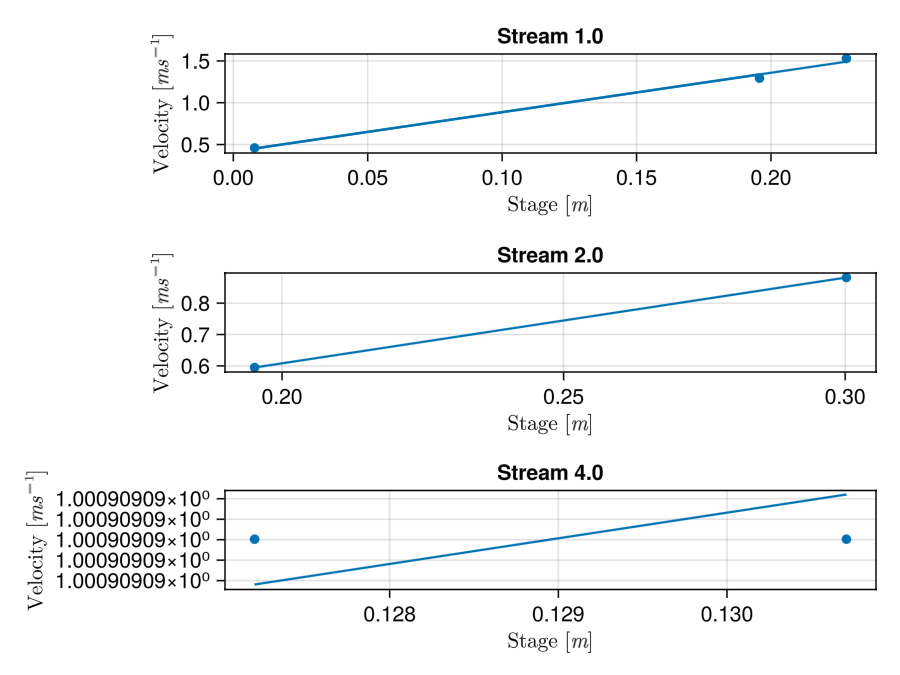

In [19]:
#linear relation v(s) using the same function as for the calibration
using GLMakie
Makie.inline!(true)
fig2 = Figure()

id = [1.0, 2.0, 4.0]
vs_rel_fn_param = Dict()

for i in range(1,3)
    velocity = []
    stage = []
    for j in keys(qsv)
        if qsv[j][1] == id[i]
            stage_temp = qsv[j][3]
            print(stage_temp)
            velocity_temp = qsv[j][4]
            push!(stage, stage_temp)
            push!(velocity, velocity_temp)
        end
    end
    
    #cali = sd_rel_values[id[i]]
    #discharge = cali[:,1]
    #stage = cali[:,2]
    # Fit line using https://github.com/JuliaOpt/LsqFit.jl
    fn(stage, p) = p[1] .+ p[2]*stage ## p[1]==a, p[2]==b
    para_weights = [0.5, 0.5] ## equal weights to parameters
    fit = curve_fit(fn, stage, velocity, para_weights)
    #errors = margin_error(fit, 1-0.95), no point with two data points
    println("""
    Estimated linear fit sensor $(id[i]): v(s) = a + b*stage with
     a = $(round(fit.param[1],sigdigits=3)), b = $(round(fit.param[2],sigdigits=3))
    """)
    vs_rel_fn_param[id[i]] = [fit.param[1], fit.param[2]]

    
    Axis(fig2[i, 1], title="Stream $(id[i])",
        xlabel=L"Stage $[m]$",
        ylabel=L"Velocity $[ms^{-1}$]")
    scatter!(stage, velocity)
    delta_fn = fn(stage, fit.param)
    #calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0.2
    """for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter!(conc, cali[:,2].-cali[1,2],
                 label="Calibration 1")"""

    # Now plot the line of best fit:
    #readouts = [i for i in 0:0.01:0.2]
    # (lines! plots a line)
    lines!(stage, fn(stage, fit.param), label="line of best fit")
    
    
end
fig2

In [20]:
vs_rel_fn_param

Dict{Any, Any} with 3 entries:
  4.0 => [1.00091, 1.25355e-10]
  2.0 => [0.0622025, 2.72999]
  1.0 => [0.415305, 4.71629]

In [21]:
#calculate width parameter

#width averages, read out from w of qsv
w1 = (2.329996920899196 + 2.2082497626135904)/2
w2 = (0.7236559574918282 + 0.8310271594893037)/2
w4 = (1.9109230779596766 + 1.6494568690486626)/2;

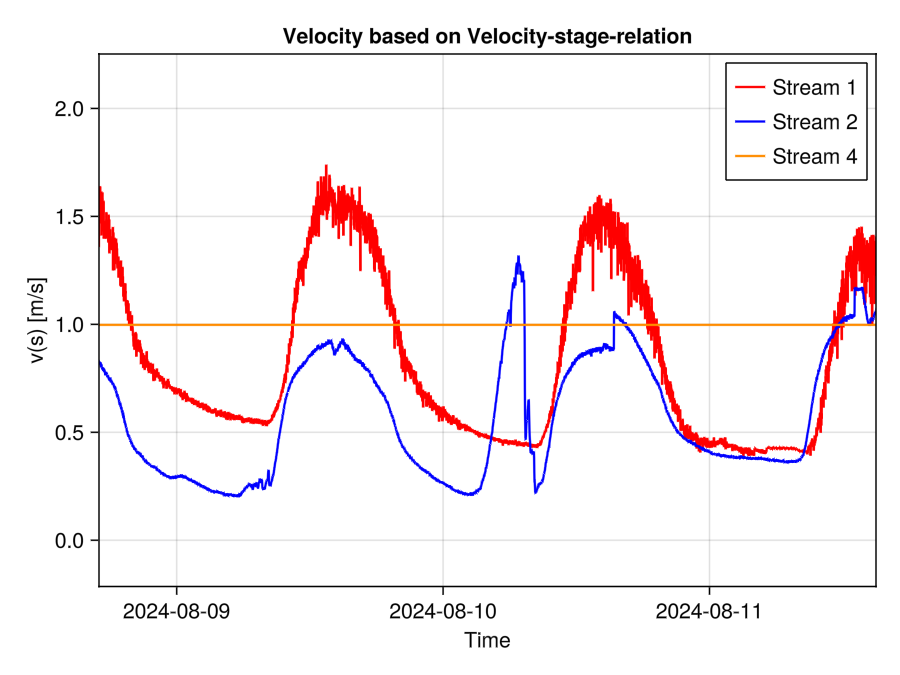

GLMakie.Screen(...)

In [22]:
#calculate v(s) with the parameters from the linear fit
# and plot Timeline of v(s)

v1 = vs_rel_fn_param[1.0][1] .+ vs_rel_fn_param[1.0][2].*sq1[:s]
v2 = vs_rel_fn_param[2.0][1] .+ vs_rel_fn_param[2.0][2].*sq2[:s]
v4 = vs_rel_fn_param[4.0][1] .+ vs_rel_fn_param[4.0][2].*sq4[:s]

#plot
fig = Figure()
colors = [:red, :blue, :green, :darkorange, :pink]
ax = Axis(fig[1,1], title = "Velocity based on Velocity-stage-relation", xlabel = "Time", ylabel = "v(s) [m/s]")
lines!(ax, sq1[:t], v1, label = "Stream 1", color = colors[1])
lines!(ax, sq2[:t], v2, label = "Stream 2", color = colors[2])
lines!(ax, sq4[:t], v4, label = "Stream 4", color = colors[4])


xmin = DateTime(2024, 8, 8, 17, 00, 0)
xmax = DateTime(2024, 8, 11, 15, 00, 0)
xlims!(ax, xmin, xmax)
#ylims!(ax, -0.1, 1.2)

axislegend(ax, position = :rt)
display(fig)

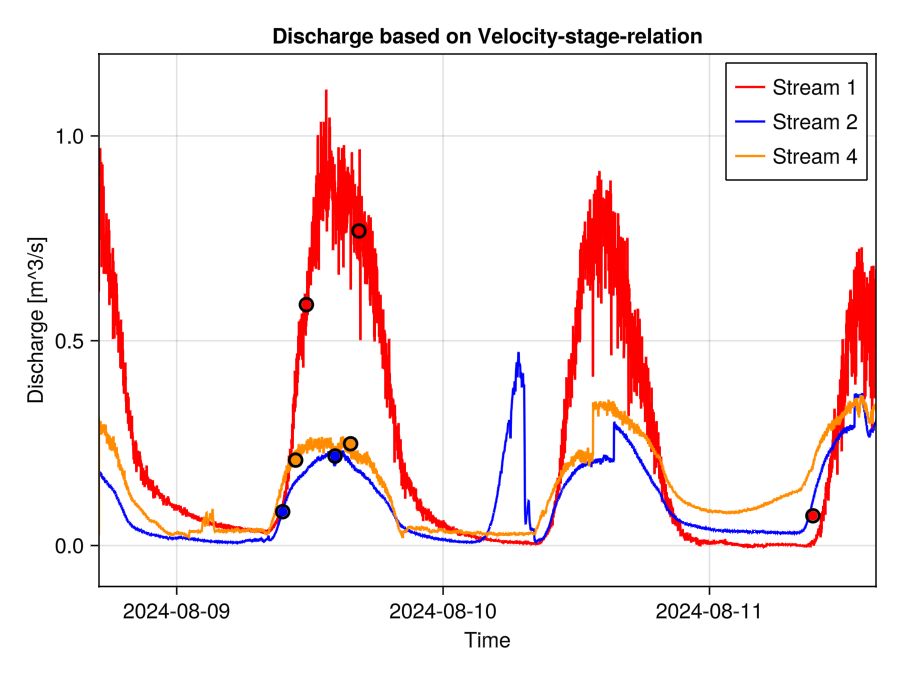

GLMakie.Screen(...)

In [23]:
#calculate and plot discharge based on v(s): q(t) = w*s*v(s) and measured discharges

Makie.inline!(true) 

#calculate discharge 
sq1[:q_v] = w1.*sq1[:s].*v1
sq2[:q_v] = w2.*sq2[:s].*v2
sq4[:q_v] = w4.*sq4[:s].*v4

fig = Figure()
colors = [:red, :blue, :green, :darkorange, :pink]
ax = Axis(fig[1,1], title = "Discharge based on Velocity-stage-relation", xlabel = "Time", ylabel = "Discharge [m^3/s]")
lines!(ax, sq1[:t], sq1[:q_v], label = "Stream 1", color = colors[1])
lines!(ax, sq2[:t], sq2[:q_v], label = "Stream 2", color = colors[2])
lines!(ax, sq4[:t], sq4[:q_v], label = "Stream 4", color = colors[4])

for i in keys(qsv) #keys are datetime, column 2 is discharge
    if qsv[i][1] != 3.0 && qsv[i][1] != 5.0 #dont show points from streams 3 and 5 (aka 1upper)
        scatter!(i, qsv[i][2], color = colors[Int(qsv[i][1])], strokecolor = :black, strokewidth = 2) #or color = lightcolors[Int(qsv[i][1])]
    end
end


xmin = DateTime(2024, 8, 8, 17, 00, 0)
xmax = DateTime(2024, 8, 11, 15, 00, 0)
xlims!(ax, xmin, xmax)
ylims!(ax, -0.1, 1.2)

axislegend(ax, position = :rt)
display(fig)

## Hydraulic friction Factor

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*